# Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import networkx as nx
pd.options.mode.chained_assignment = None 

DATA_PATH = './data/'

In [2]:
women_players_info = pd.read_csv(DATA_PATH + 'women_players_info.csv')
men_players_info = pd.read_csv(DATA_PATH + 'men_players_info.csv')

women_finals = pd.read_csv(DATA_PATH + 'women_finals.csv')
print("Number of women's matches: " + str(len(women_finals)))
women_finals.sample(3)

Number of women's matches: 445


,Year,Tournament,Winner,Runner-up,Score
131,1988,Australian Open,Steffi Graf,Chris Evert,"6–1, 7–6(3)"
380,1919,U.S. National Championships,Hazel Hotchkiss Wightman,Marion Zinderstein,"6–1, 6–2"
229,1963,Wimbledon Championships,Margaret Smith,Billie Jean Moffitt,"6–3, 6–4"


In [3]:
men_finals = pd.read_csv(DATA_PATH + 'men_finals.csv')
print("Number of men's matches: " + str(len(men_finals)))
men_finals.sample(3)

Number of men's matches: 472


,Year,Tournament,Winner,Runner-up,Score
182,1975,French Open,Björn Borg,Guillermo Vilas,"6–2, 6–3, 6–4"
277,1951,Wimbledon Championships,R. Savitt,Ken McGregor,"6–4, 6–4, 6–4"
471,1877,Wimbledon Championships,Spencer Gore,William Marshall,"6–1, 6–2, 6–4"


There seems to be a problem converting year to numeric. This is because two Australian Opens took place in 1977 – one in early January, one in late December. However, the later one belonged to the 1978 Grand Slam season, so for simplicity, we will change the year.

In [4]:
all(men_finals.Year.str.isnumeric()) 

False

In [5]:
wrong_date = ~men_finals.Year.str.isnumeric()
men_finals[wrong_date]

,Year,Tournament,Winner,Runner-up,Score
171,1977 (2),Australian Open,Vitas Gerulaitis,John Lloyd,"6–3, 7–6, 5–7, 3–6, 6–2"
175,1977 (1),Australian Open,Roscoe Tanner,Guillermo Vilas,"6–3, 6–3, 6–3"


In [6]:
men_finals.at[wrong_date, 'Year'] = 1978
women_finals.at[wrong_date, 'Year'] = 1978

men_finals['Year'] = men_finals['Year'].apply(pd.to_numeric)
women_finals['Year'] = women_finals['Year'].apply(pd.to_numeric)

In [7]:
# drop data from before Open Era 
men = men_finals[(men_finals.Year > 1967) & (men_finals.Tournament != 'Australian Championships')]
women = women_finals[(women_finals.Year > 1967) & (women_finals.Tournament != 'Australian Championships')]

In [8]:
# shorten name
men.loc[men.Tournament == 'Wimbledon Championships (Open Era)','Tournament'] = 'Wimbledon'
women.loc[women.Tournament == 'Wimbledon Championships (Open Era)','Tournament'] = 'Wimbledon'
women.loc[women.Tournament == 'U.S. Open','Tournament'] = 'US Open'

In [9]:
print("Number of men's matches (Open Era): " + str(len(men)))
print("Number of women's matches (Open Era): " + str(len(women)))

Number of men's matches (Open Era): 211
Number of women's matches (Open Era): 211


# Exploratory Data Analysis

In [10]:
def plot_tournaments(gender):
    for which in ['Winner', 'Runner-up']:
        df = gender.groupby([which, 'Tournament']).agg({which: 'count'}).rename(columns={which: 'count'}).unstack().fillna(0)
        df['total'] = df.sum(axis=1)
        
        df = df.sort_values(by=['total'], ascending=False)
        print(df.head())
        df = df.drop(columns=['total'])
        fig = df.plot(kind='bar', stacked=True, figsize=(15, 5))
        plt.ylabel('count')
        plt.legend(['Australian Open', 'French Open', 'US Open', 'Wimbledon'])
        plt.show()

                         count                               total
Tournament     Australian Open French Open US Open Wimbledon      
Winner                                                            
Rafael Nadal               1.0        13.0     4.0       2.0  20.0
Roger Federer              6.0         1.0     5.0       8.0  20.0
Novak Djokovic             9.0         1.0     3.0       5.0  18.0
Pete Sampras               2.0         0.0     5.0       7.0  14.0
Björn Borg                 0.0         6.0     0.0       5.0  11.0


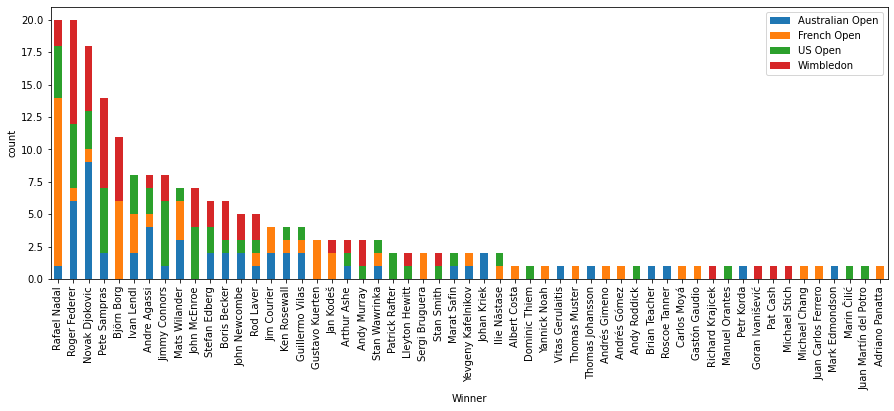

                         count                               total
Tournament     Australian Open French Open US Open Wimbledon      
Runner-up                                                         
Roger Federer              1.0         4.0     2.0       4.0  11.0
Ivan Lendl                 2.0         2.0     5.0       2.0  11.0
Novak Djokovic             0.0         4.0     5.0       1.0  10.0
Andy Murray                5.0         1.0     1.0       1.0   8.0
Rafael Nadal               4.0         0.0     1.0       3.0   8.0


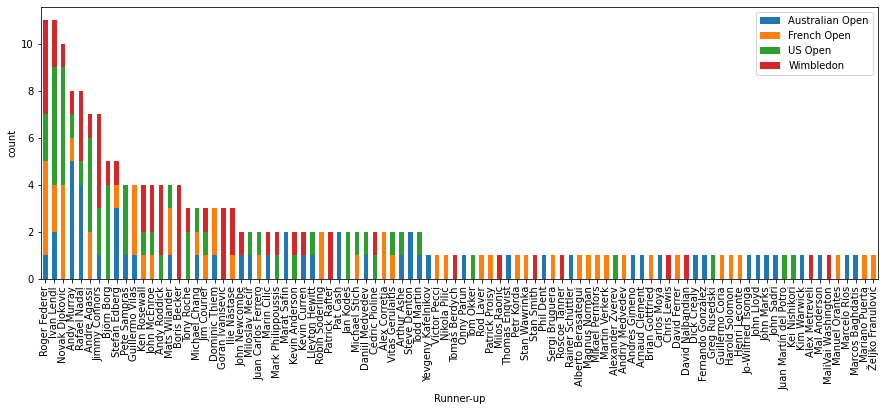

In [11]:
plot_tournaments(men)

                              count                               total
Tournament          Australian Open French Open US Open Wimbledon      
Winner                                                                 
Serena Williams                 7.0         3.0     6.0       7.0  23.0
Steffi Graf                     4.0         6.0     5.0       7.0  22.0
Chris Evert                     2.0         7.0     6.0       3.0  18.0
Martina Navratilova             3.0         2.0     4.0       9.0  18.0
Margaret Court                  4.0         3.0     3.0       1.0  11.0


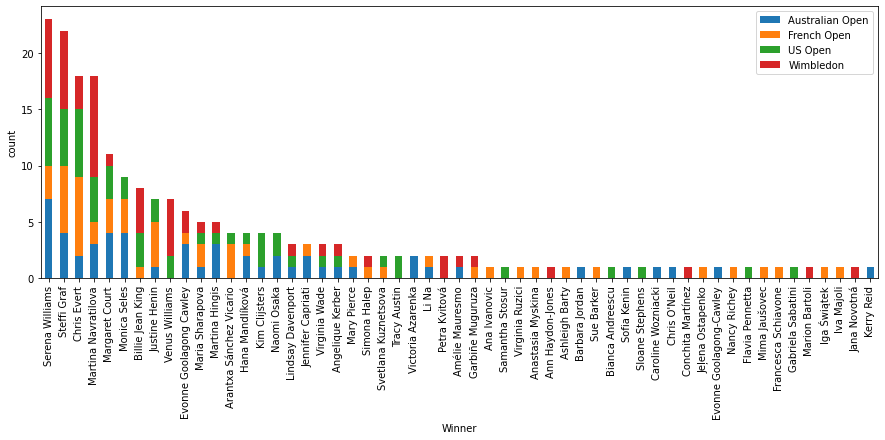

                                  count                               total
Tournament              Australian Open French Open US Open Wimbledon      
Runner-up                                                                  
Chris Evert                         4.0         2.0     3.0       7.0  16.0
Martina Navratilova                 3.0         4.0     4.0       3.0  14.0
Evonne Goolagong Cawley             3.0         1.0     4.0       3.0  11.0
Serena Williams                     1.0         1.0     4.0       4.0  10.0
Steffi Graf                         1.0         3.0     3.0       2.0   9.0


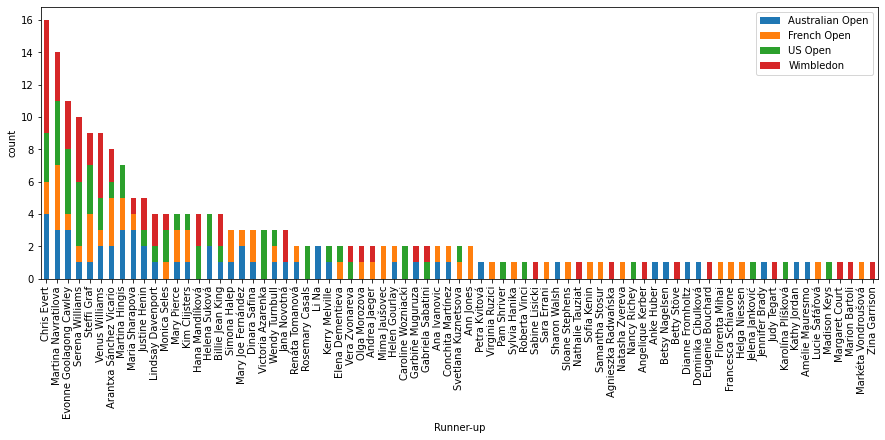

In [12]:
plot_tournaments(women)

In [13]:
winners_men = men['Winner'].unique().tolist()
rups_men = men['Runner-up'].unique().tolist()
men_players = set(winners_men + rups_men)
n_men = len(men_players)

print('Number of different Grand Slam winners (men): ' + str(len(winners_men)))
print('Number of different Grand Slam finalists (men): ' + str(n_men))

Number of different Grand Slam winners (men): 55
Number of different Grand Slam finalists (men): 106


In [14]:
winners_women = women['Winner'].unique().tolist()
rups_women = women['Runner-up'].unique().tolist()
women_players = set(winners_women + rups_women)
n_women = len(women_players)

print('Number of different Grand Slam winners (women): ' + str(len(winners_women)))
print('Number of different Grand Slam finalists (women): ' + str(n_women))

Number of different Grand Slam winners (women): 55
Number of different Grand Slam finalists (women): 94


In [15]:
men_players_data = men_players_info[men_players_info.Name.isin(men_players)]
assert(n_men == len(men_players_data))

women_players_data = women_players_info[women_players_info.Name.isin(women_players)]
assert(n_women == len(women_players_data))

In [16]:
def plot_network(gender):
    matches = nx.Graph()

    pairs = []
    for idx, values in enumerate(np.sort(gender[['Winner','Runner-up']], axis=1)):
        pairs.append(tuple(values))
    pairs_counted = collections.Counter(pairs)

    for key in pairs_counted:
        matches.add_edge(key[0], key[1], weight=pairs_counted[key])

    edges = matches.edges()
    weights = [1.5*matches[u][v]['weight'] for u,v in edges]

    plt.figure(figsize=(40,40)) 
    nx.draw(matches, with_labels=True, alpha = 0.75, node_size=50, width=weights, font_size=20)

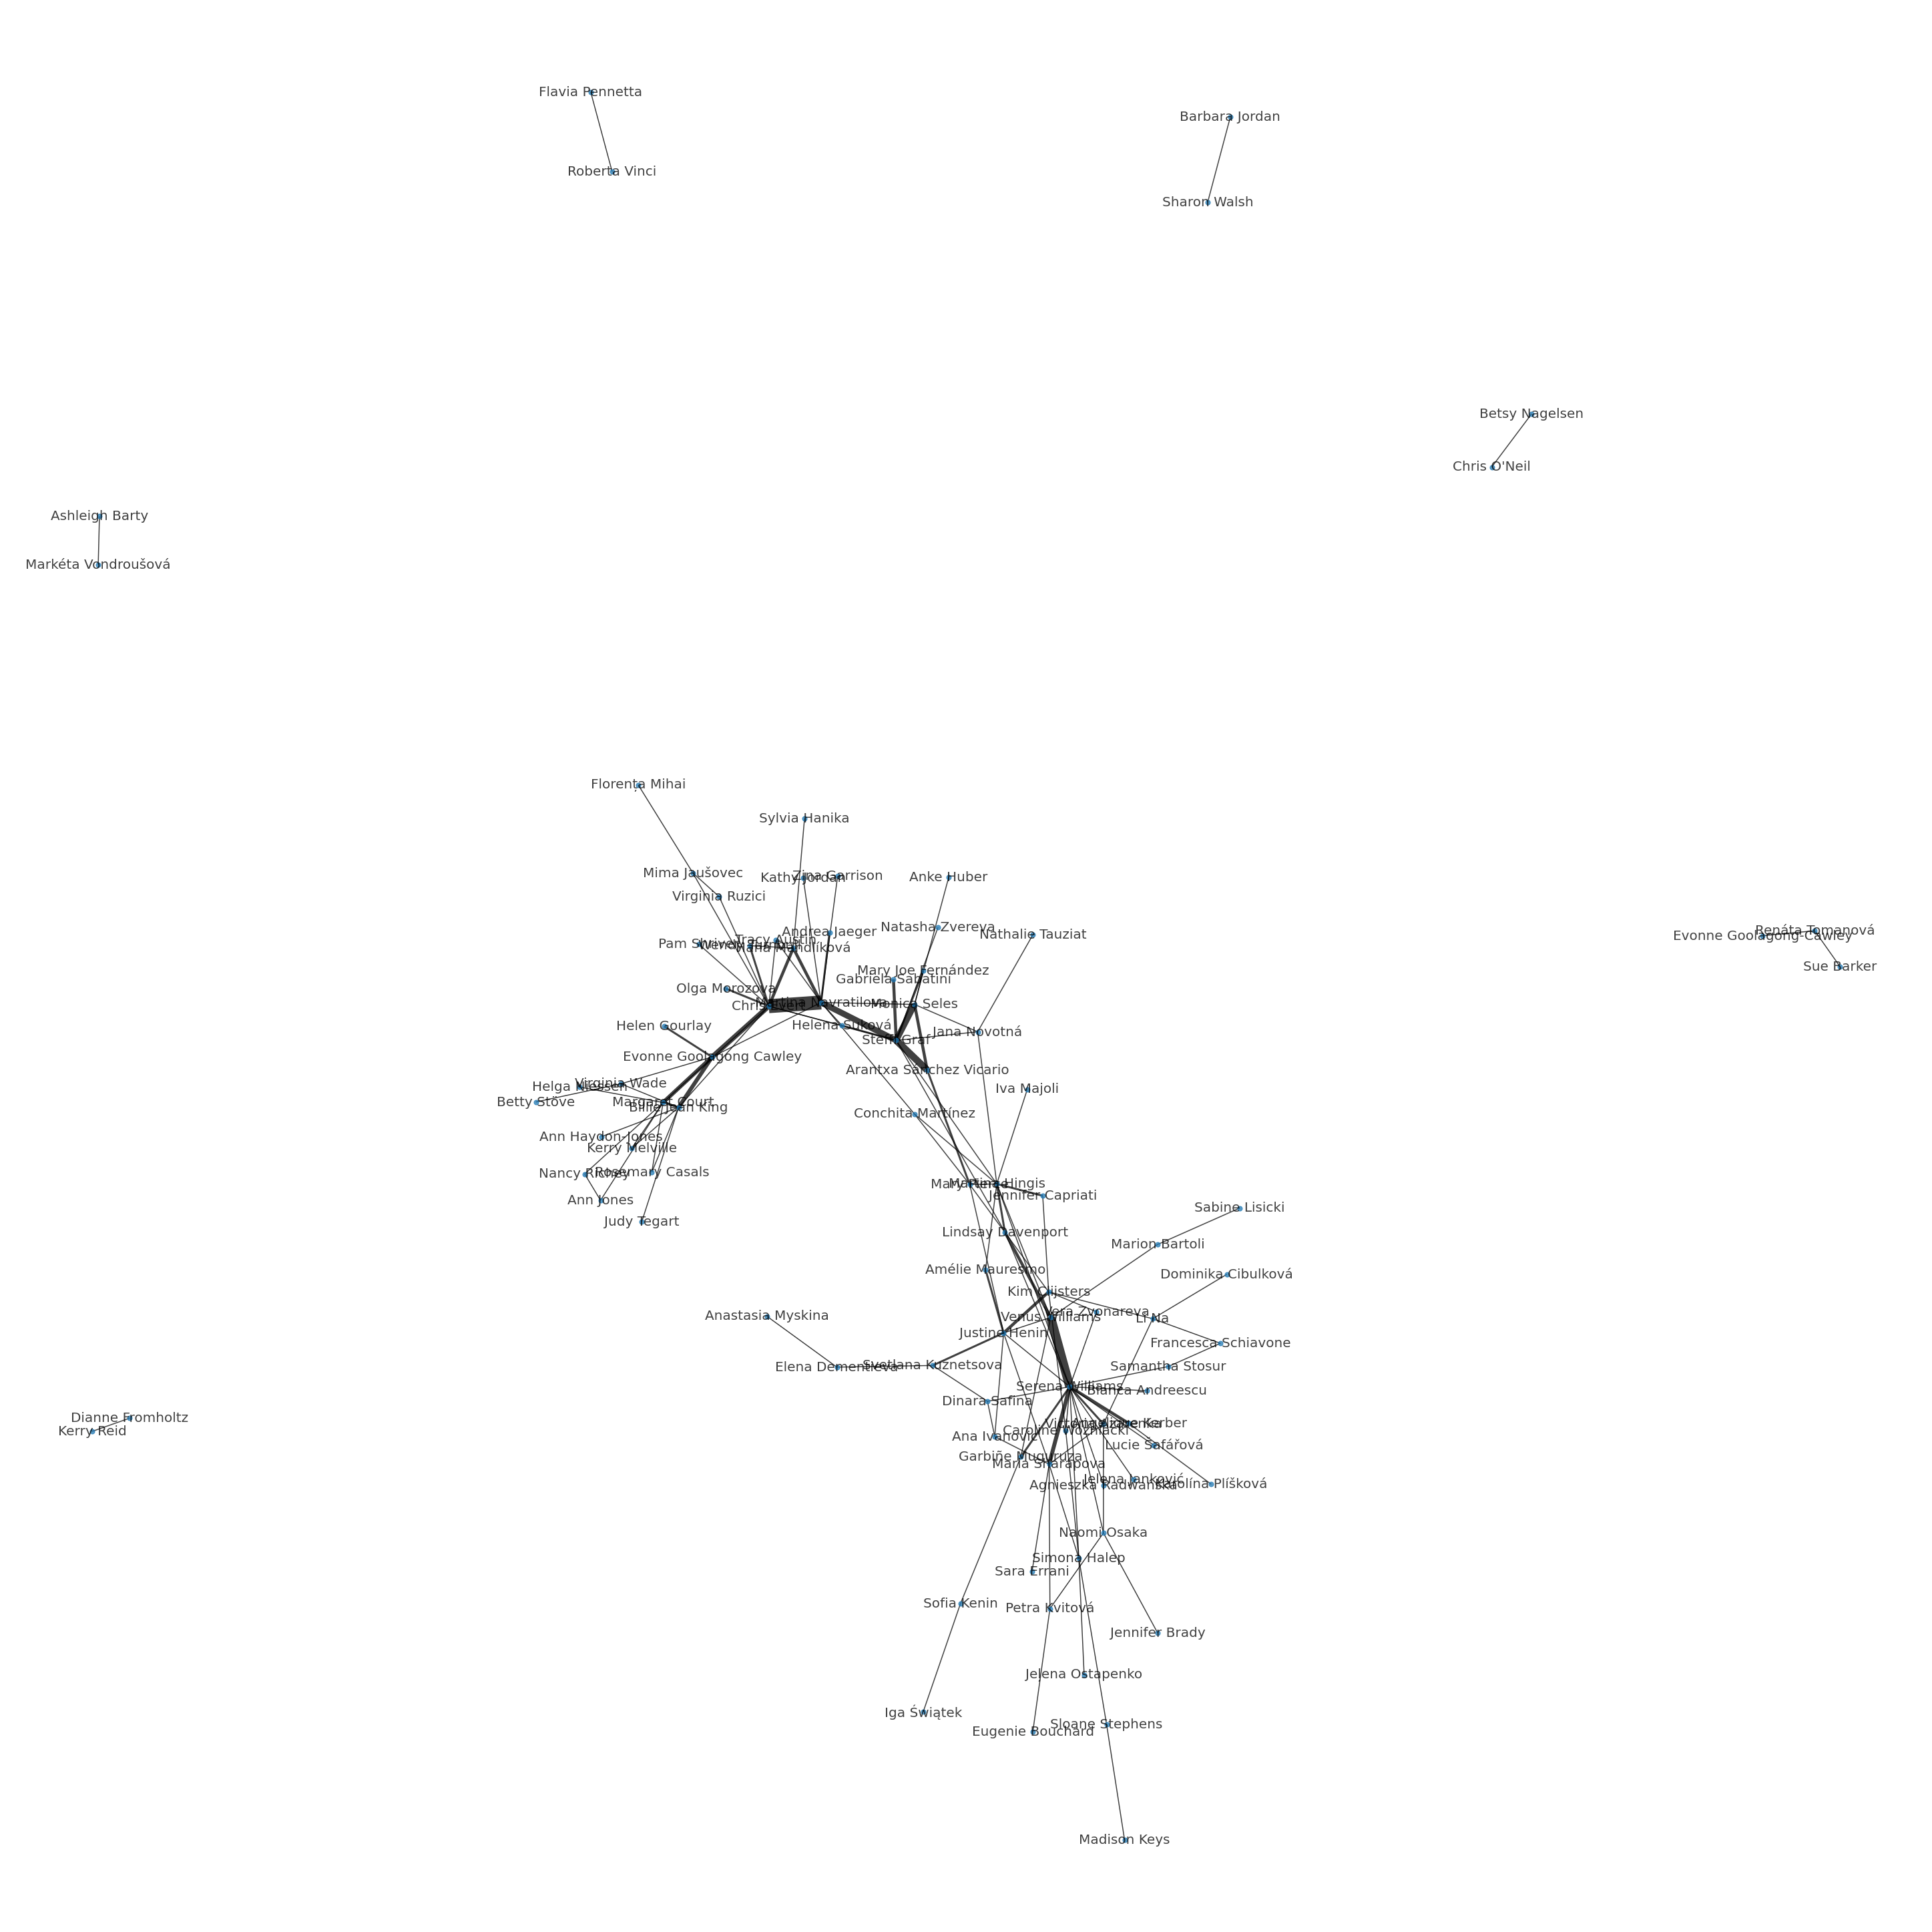

In [23]:
plot_network(women)
plt.savefig(DATA_PATH + "img/network_women.png")

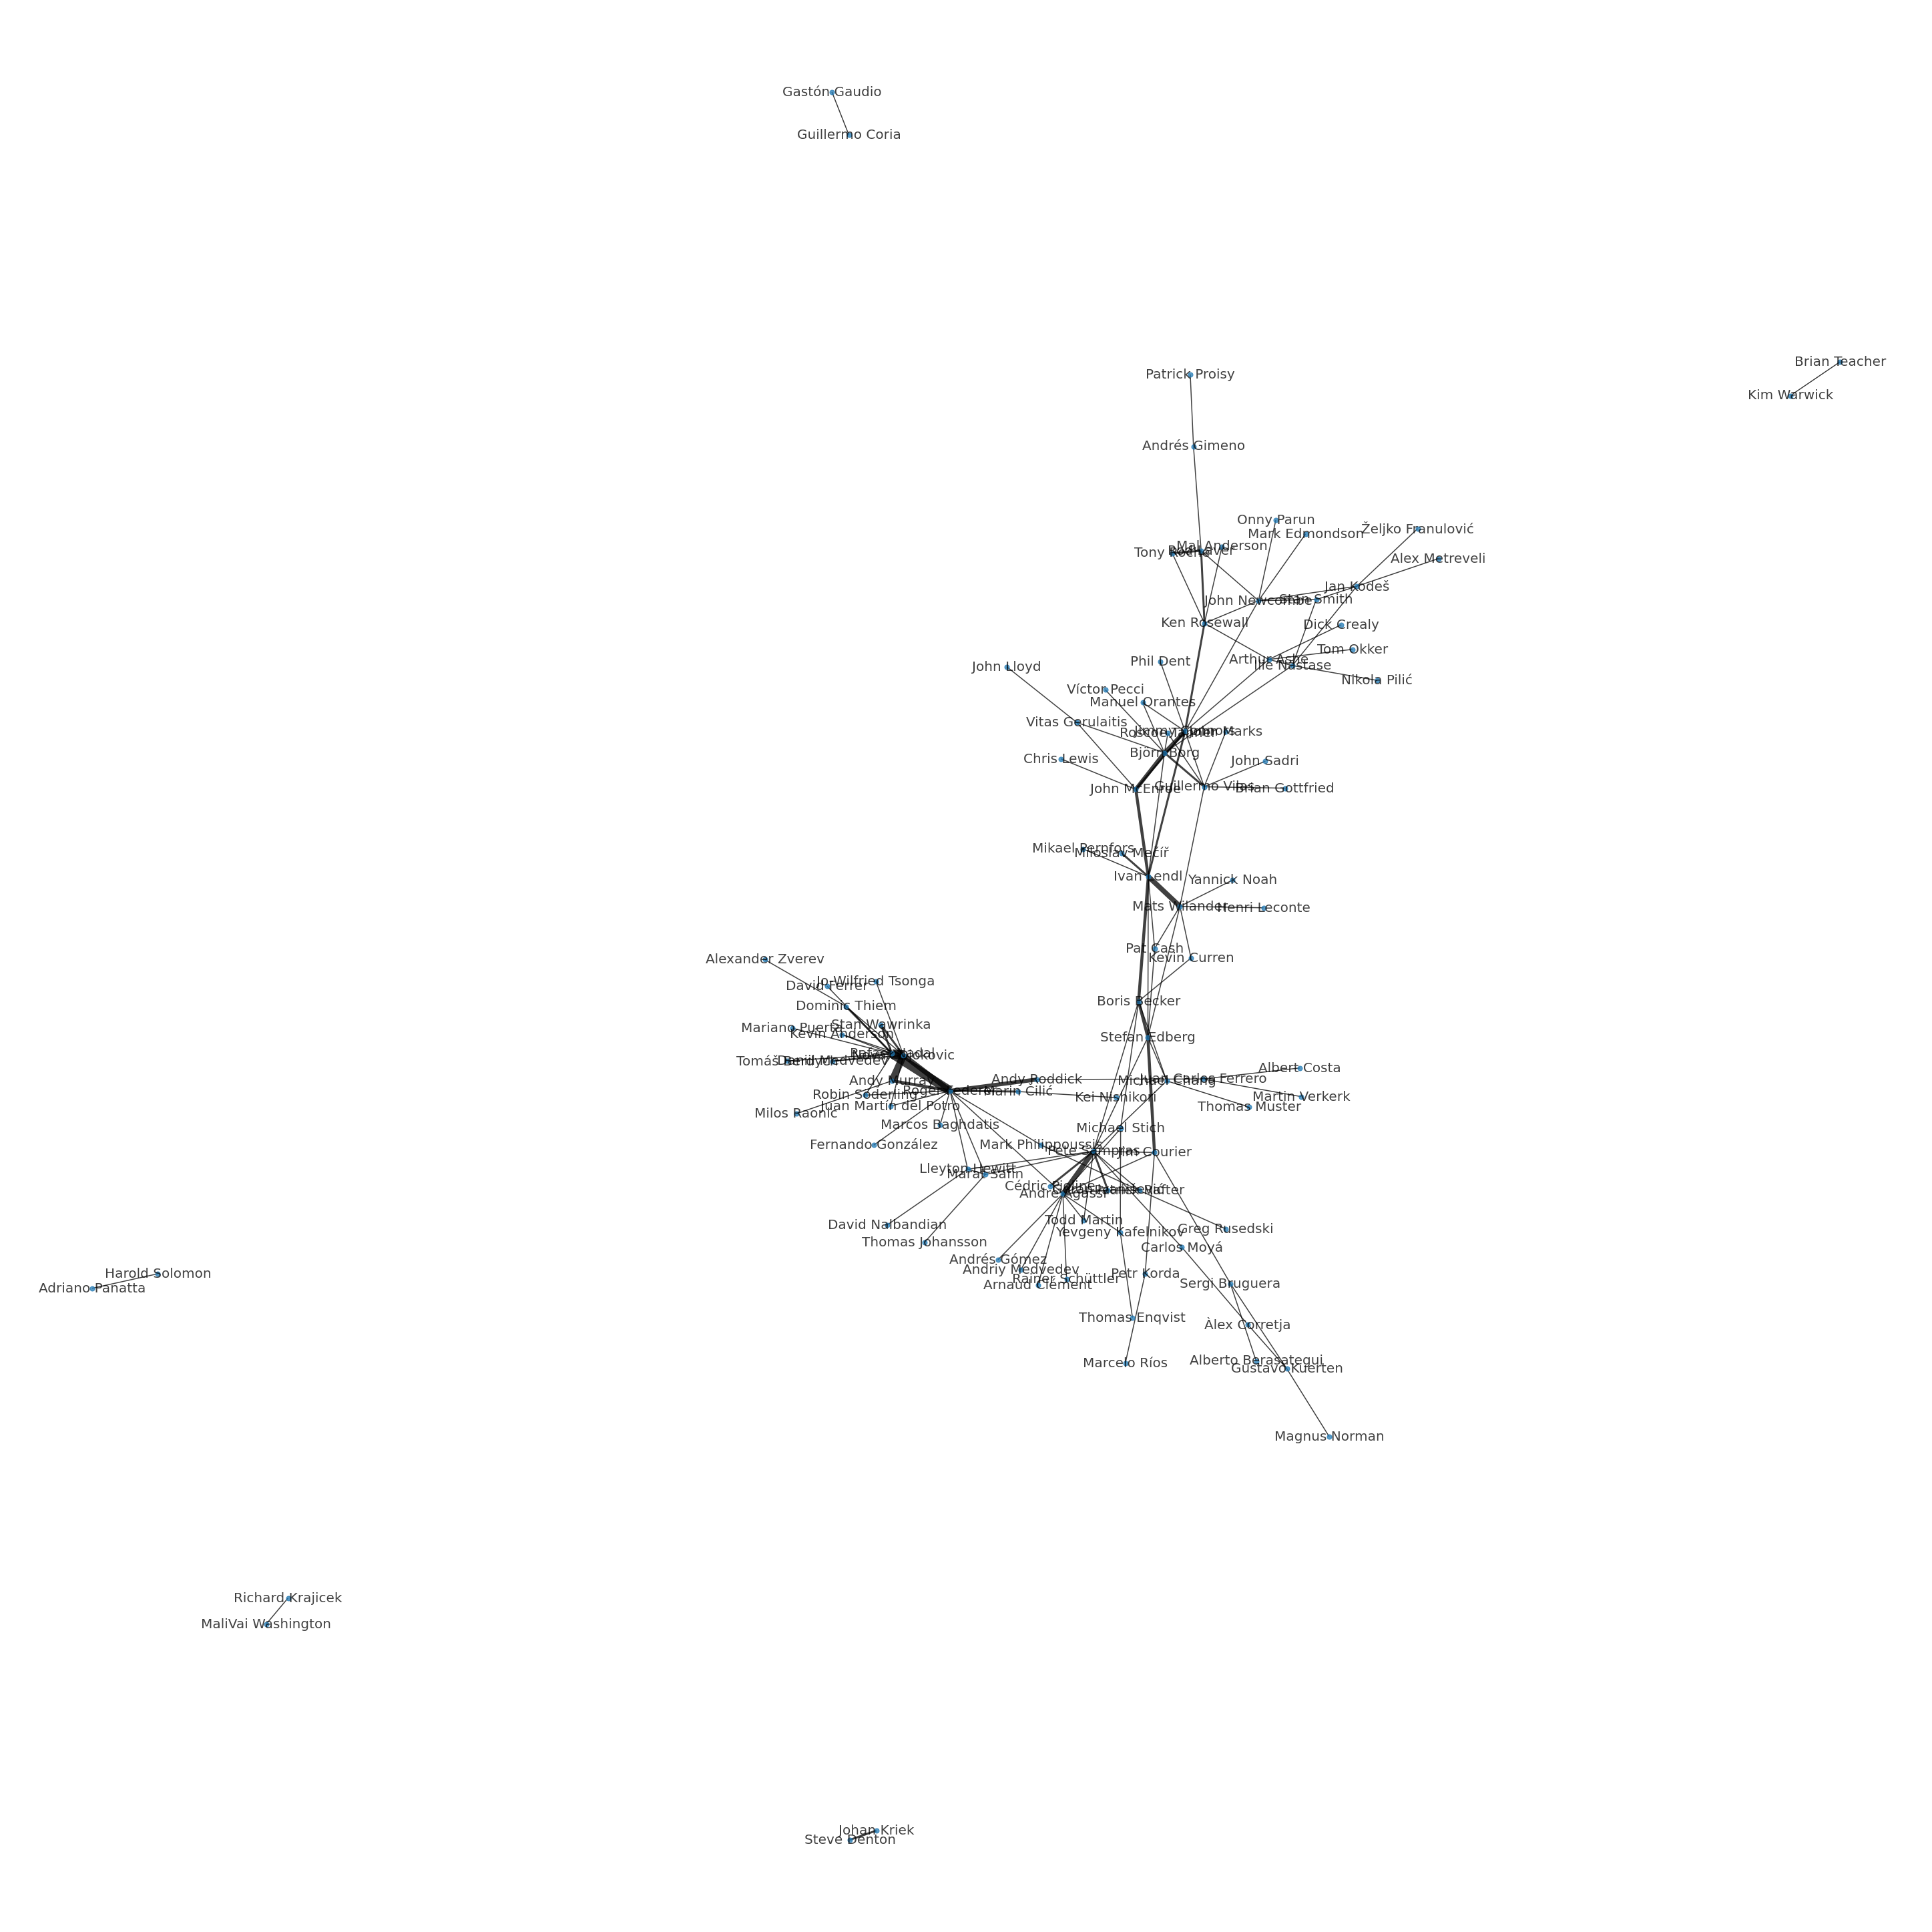

In [24]:
plot_network(men)
plt.savefig(DATA_PATH + "img/network_men.png")

In [19]:
# group by decade - not ideal for static notebook... maybe let's leave it for the D3 implementation
men.groupby([men.Year // 10 * 10, 'Winner']).agg({'Tournament': 'count'}).rename(columns={'Tournament': 'count'})

count
Year Winner                
1960 Arthur Ashe          1
     Ken Rosewall         1
     Rod Laver            5
1970 Adriano Panatta      1
     Andrés Gimeno        1
...                     ...
2010 Roger Federer        5
     Stan Wawrinka        3
2020 Dominic Thiem        1
     Novak Djokovic       2
     Rafael Nadal         1

[71 rows x 1 columns]

In [20]:
women_players_data.head()

,Name,Full name,Country (sports),Residence,Born,Height,Turned pro,Retired,Plays,Coach,...,Official website,College,Nickname(s),National team,Weight,ITF name,Batting,Bowling,Listed height,Listed weight
0,Chris O'Neil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chris Evert,Christine Marie Evert,United States,"Boca Raton, Florida",1954-12-21,1.68 m,1972,"September 5, 1989",Right-handed (two-handed backhand),Jimmy EvertDennis Ralston[2],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Conchita Martínez,Inmaculada Concepción Martínez Bernat,Spain,"Barcelona, Spain San Diego, California, U.S.",1972-04-16,1.73 m,February 1988,15 April 2006,Right-handed (one-handed backhand),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Naomi Osaka,NaN,Japan,"Beverly Hills, California, U.S.",1997-10-16,1.80 m,September 2013,NaN,Right-handed (two-handed backhand),Wim Fissette (2020–),...,naomiosaka.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Caroline Wozniacki,NaN,Denmark,"Fisher Island, United StatesOdense, DenmarkMon...",1990-07-11,1.77 m,18 July 2005[1],24 January 2020,Right-handed (two-handed backhand)[1],Piotr Woźniacki (2004–2020),...,carolinewozniacki.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
match_data = pd.read_csv(DATA_PATH + 'men_match_stats.csv')
match_data.head()

,Tournament,Date,Participation,Winner,Runner-up,Final Score,Overview_Serve_Ace %_Winner,Overview_Serve_Ace %_Runner-up,Overview_Serve_Double Fault %_Winner,Overview_Serve_Double Fault %_Runner-up,...,Total_Points & Games_Total Games Won_Winner,Total_Points & Games_Games Won %_Winner,Total_Points & Games_Games Won %_Runner-up,Total_Dominance_Points Dominance_Winner,Total_Dominance_Games Dominance_Winner,Total_Dominance_Break Points Ratio_Winner,Total_Time_Point Time (seconds)_Winner,Total_Time_Game Time (minutes)_Winner,Total_Time_Set Time (minutes)_Winner,Total_Time_Match Time_Winner
0,Roland Garros 2020,28-09-2020,91.4%,Rafael Nadal,Novak Djokovic,6-0 6-2 7-5,4 / 84,1 / 99,1 / 84,4 / 99,...,7,19 / 26,7 / 26,0.66,0.14,0.51,52.8,6.19,53.7,2:41
1,Roland Garros 2019,27-05-2019,89.4%,Rafael Nadal,Dominic Thiem,6-3 5-7 6-1 6-1,3 / 106,7 / 92,0 / 106,1 / 92,...,12,23 / 35,12 / 35,0.66,0.27,0.62,54.8,5.17,45.3,3:01
2,Roland Garros 2018,28-05-2018,86.5%,Rafael Nadal,Dominic Thiem,6-4 6-3 6-2,0 / 82,7 / 102,3 / 82,5 / 102,...,9,18 / 27,9 / 27,0.64,0.19,1.13,52.8,6.00,54.0,2:42
3,Roland Garros 2017,29-05-2017,94.5%,Rafael Nadal,Stan Wawrinka,6-2 6-3 6-1,4 / 65,1 / 86,0 / 65,0 / 86,...,6,18 / 24,6 / 24,0.45,0.00,0.00,49.7,5.21,41.7,2:05
4,Roland Garros 2016,23-05-2016,91.0%,Novak Djokovic,Andy Murray,3-6 6-1 6-2 6-4,4 / 110,5 / 109,3 / 110,3 / 109,...,13,21 / 34,13 / 34,0.77,0.43,0.60,50.1,5.38,45.8,3:03
